In [14]:
import os
import cv2
import pandas as pd 
import matplotlib.pyplot as plt

IMG_DIM = 256

def squareUp(rgb):
    
    gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
    
    thresh = 5
    
    # remove any black regions, where black is y under the threshold
    rowMaxes = gray.max(axis=1)
    top = 0
    while rowMaxes[top] < thresh:
        top += 1
    bottom = len(rowMaxes) - 1
    while rowMaxes[bottom] < thresh:
        bottom -= 1
        
    middleRow = gray[int((bottom-top)/2)]
    left = 0
    while middleRow[left] < thresh:
        left += 1
    right = len(middleRow) - 1
    while middleRow[right] < thresh:
        right -= 1
        
    height = bottom - top
    width  = right - left
        
    if height < 100 or width < 100:
        print("Error: squareUp: bottom:", bottom, "top:", top)
        print("Error: squareUp: right:", right, "left:", left)
        return rgb
    
    rgb = rgb[top:bottom, left:right]
    
    return cv2.resize(rgb, (IMG_DIM, IMG_DIM))

# assumes BGR
def colourfulEyes(img, weight=4, gamma=15):
    
    # crop out black - no point if we are zooming in anyway
    img = squareUp(img) 
        
    # convert to y, cr, cb so that we can modify the image based on just the y (brightness)
    ycc = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycc)

    # perform bens algorithm on the y component
    y = cv2.addWeighted(y, weight, cv2.GaussianBlur(y, (0,0), gamma), -weight, 128)

    # merge the ycc back together, and recolor it
    ycc_modified = cv2.merge((y, cr, cb))
    rgb_modified = cv2.cvtColor(ycc_modified, cv2.COLOR_YCrCb2BGR)
    
    return rgb_modified 

In [ ]:
# directory = "../aptos2019/train_images/" 
directory = "../aptos2015/train_images/" 
count = 0
for file in os.listdir(directory):
    
    # check an image
#     if not file.endswith(".png"): 
    if not file.endswith(".jpeg"): 
        print("found weird file:", file)
        exit()
        
    # check an original
#     if "modified" in file:
#         continue
        
    
    count += 1
    if count % 100 == 0:
        print(count)
        
    if count < 4800:
        continue
    
    file_old = directory + file
#     file_new = directory + "modified_" + file
    
    # check not already modified
#     if os.path.isfile(file_new):
#         continue
        
    img = cv2.imread(file_old)
    modified = colourfulEyes(img)
#     cv2.imwrite(file_new, modified)
    cv2.imwrite(file_old, modified)
    
    
 #2200

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

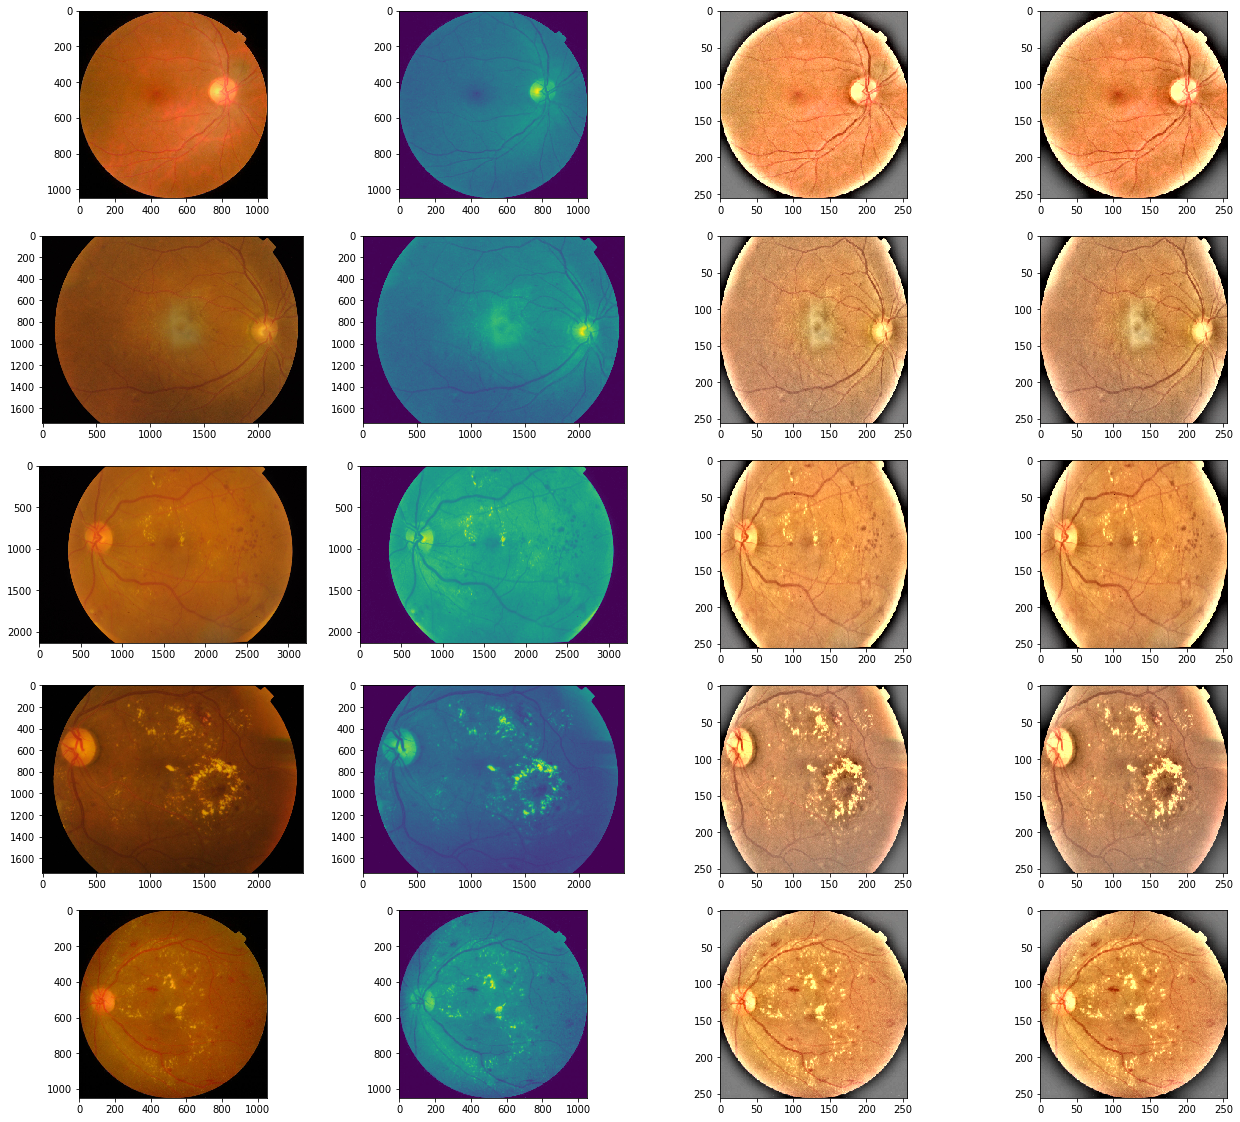

In [23]:
# Test different versions of colourful eyes

# the main dataframes
df_2019 = pd.read_csv(f"../aptos2019/train.csv") 
# df_2015 = pd.read_csv(f"../aptos2015/trainLabels.csv") 
df_2019.id_code = df_2019.id_code.apply(lambda x: x + ".png")
# df_2015.image   = df_2015.image.apply(lambda   x: x + ".jpeg")

# Display some random images from Data Set with class categories.
figure=plt.figure(figsize=(22,20))
for target_class in (df_2019['diagnosis'].unique()):
    for i, (idx, row ) in enumerate(df_2019.loc[df_2019.diagnosis == target_class]
                                    .sample(1)
                                    .iterrows()):
        # open the file
        imagefile = f"../aptos2019/train_images/{row['id_code']}" 
        img = cv2.imread(imagefile)
        
        # original version
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = figure.add_subplot(5,4, int(target_class)*4+4*i+1)
        plt.imshow(rgb)
        
        # colored versions with diff gammas
        green = rgb[:,:,1]
        ax = figure.add_subplot(5,4, int(target_class)*4+4*i+2)
        plt.imshow(green)

        # colored version
        funky = colourfulEyes(rgb, 4, 10)
        ax = figure.add_subplot(5,4, int(target_class)*4+4*i+3)
        plt.imshow(funky)

        # colored version
        funky = colourfulEyes(rgb, 4, 15)
        ax = figure.add_subplot(5,4, int(target_class)*4+4*i+4)
        plt.imshow(funky)